In [195]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
import shap
import scipy
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV

In [147]:
data = pd.read_csv('Video_Games_Sales.csv')

In [148]:
print(data.head())

                       Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   Critic_Count User_Score  User_Count Developer Rating 

In [149]:
# Display the data types and check for presence of missing values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB
None


In [150]:
# Convert 'User_Score' to numeric
data['User_Score'] = pd.to_numeric(data['User_Score'], errors='coerce')

In [151]:
# Fill missing 'Year_of_Release' with the median year
data['Year_of_Release'].fillna(data['Year_of_Release'].median(), inplace=True)

In [152]:
# Fill missing 'Publisher', "Genre", 'Rating' with the mode 
for column in ['Publisher', 'Genre', 'Rating']:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

In [153]:
# Impute numeric columns like 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'
# with their median values
for column in ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']:
    median_value = data[column].median()
    data[column].fillna(median_value, inplace=True)

In [108]:
# Check the updated data info to confirm changes
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16719 non-null  float64
 3   Genre            16719 non-null  object 
 4   Publisher        16719 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     16719 non-null  float64
 11  Critic_Count     16719 non-null  float64
 12  User_Score       16719 non-null  float64
 13  User_Count       16719 non-null  float64
 14  Developer        10096 non-null  object 
 15  Rating           16719 non-null  object 
dtypes: float64(10), object(6)
memory usage: 2.0+ MB
None


In [223]:
num_cols = data.columns.drop("EU_Sales")

# Summary statistics for numerical features
print(data[num_cols].describe())

       Year_of_Release      NA_Sales      JP_Sales   Other_Sales  \
count     16719.000000  16719.000000  16719.000000  16719.000000   
mean       2006.495604      0.263330      0.077602      0.047332   
std           5.831862      0.813514      0.308818      0.186710   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.000000      0.010000   
75%        2010.000000      0.240000      0.040000      0.030000   
max        2020.000000     41.360000     10.220000     10.570000   

       Global_Sales  Critic_Score  Critic_Count   User_Score    User_Count  
count  16719.000000  16719.000000  16719.000000  16719.00000  16719.000000  
mean       0.533543     70.010886     23.609068      7.32978     86.752856  
std        1.547935      9.776336     13.509406      1.02773    384.376835  
min        0.010000     13.000000      3.000000      0.00000      4.000000  
25

In [219]:
# List all categorical columns excluding 'Name'
categorical_cols = data.select_dtypes(include='object').columns.drop('Name')

# Display statistics for the categorical columns
print(data[categorical_cols].describe())

       Platform   Genre        Publisher Developer Rating
count     16719   16719            16719     10096  16719
unique       31      12              581      1696      8
top         PS2  Action  Electronic Arts   Ubisoft      E
freq       2161    3372             1410       204  10760


c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


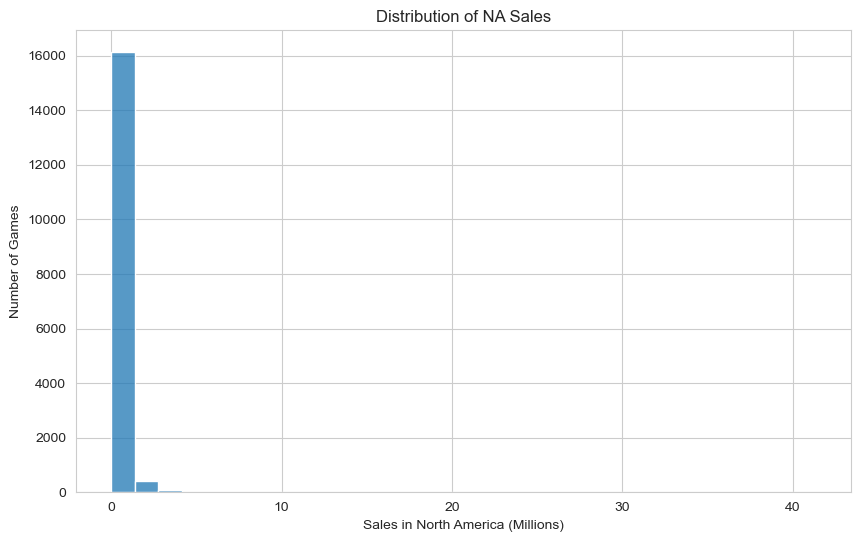

In [110]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Histogram of NA_Sales
plt.figure(figsize=(10, 6))
sns.histplot(data['NA_Sales'], bins=30, kde=False)
plt.title('Distribution of NA Sales')
plt.xlabel('Sales in North America (Millions)')
plt.ylabel('Number of Games')
plt.show()

In [203]:
# log transformation due to right skewed data
log_sales = np.log1p(data["NA_Sales"])

In [208]:
# Calculate variance of the log-transformed sales data
variance_log_sales = np.var(log_sales)

print(variance_log_sales)

0.07909718457115576


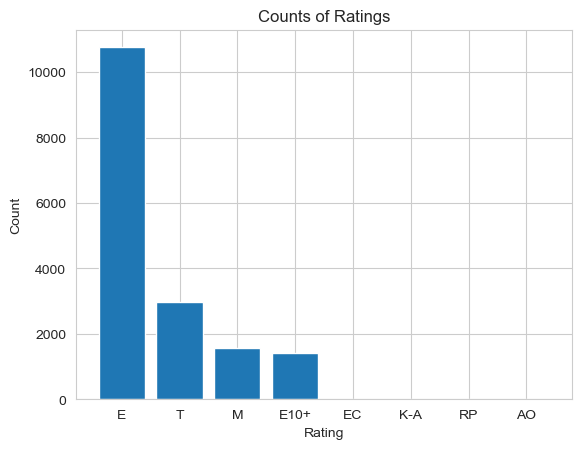

In [36]:
# Plot of counts of ratings
ratings_counts = data['Rating'].value_counts()

# Create bar plot
plt.bar(ratings_counts.index, ratings_counts.values)

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Counts of Ratings')

# Show the plot
plt.show()

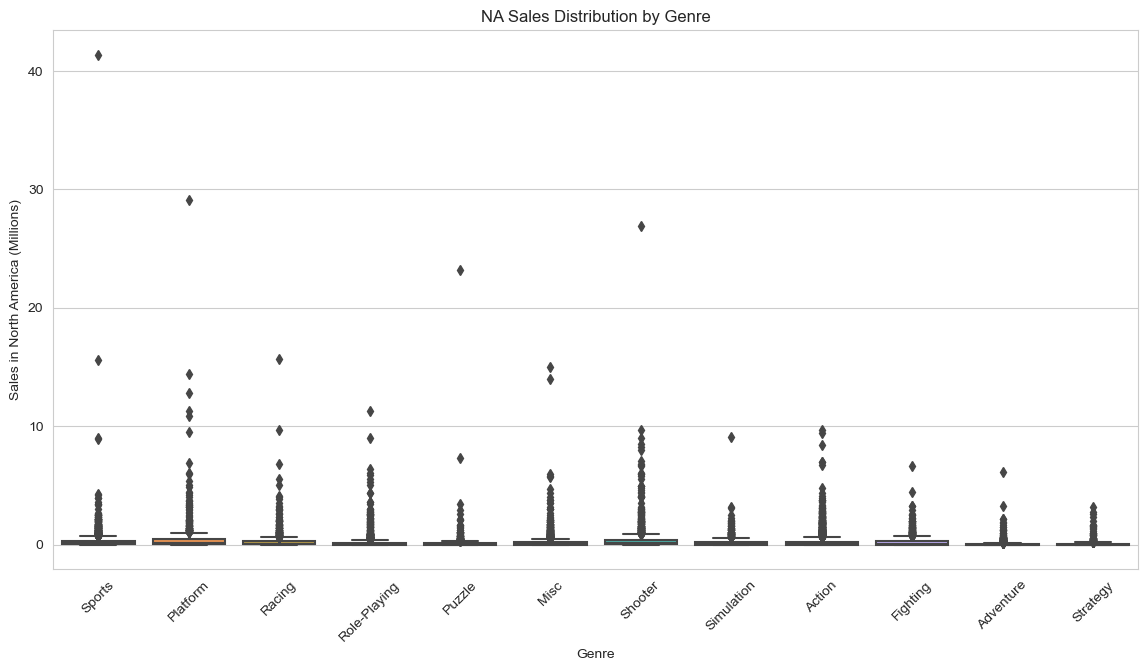

In [37]:
# Boxplot to compare sales across different genres
plt.figure(figsize=(14, 7))
sns.boxplot(x='Genre', y='NA_Sales', data=data)
plt.title('NA Sales Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Sales in North America (Millions)')
plt.xticks(rotation=45)
plt.show()

c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


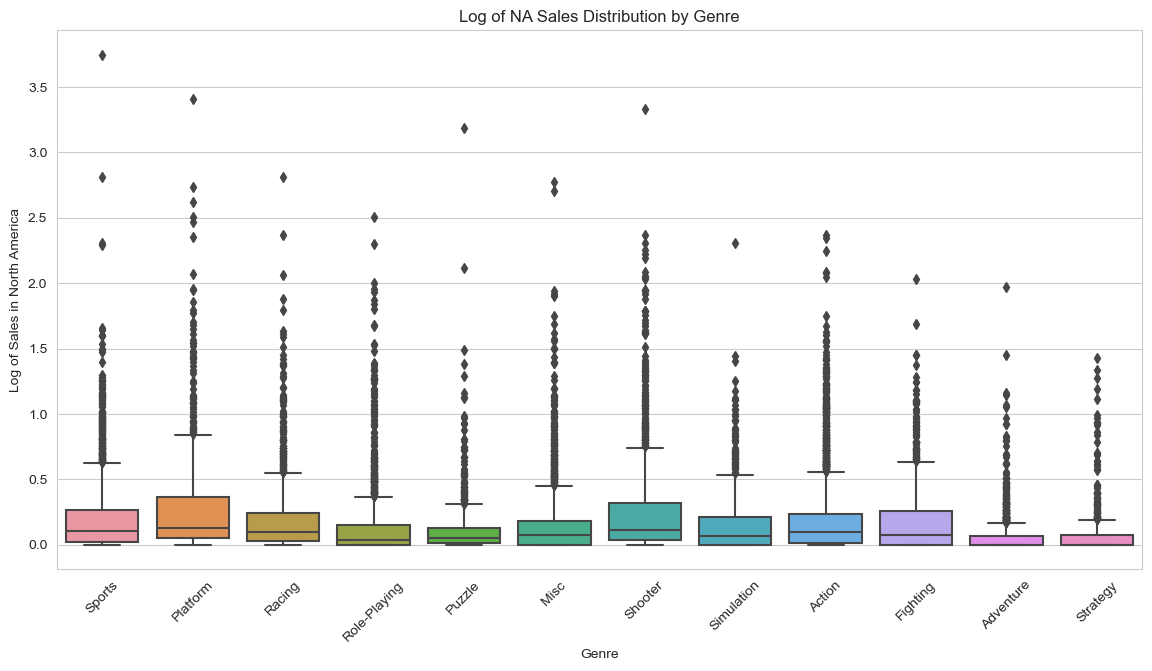

In [207]:
# Boxplot to compare sales across different genres
plt.figure(figsize=(14, 7))
sns.boxplot(x='Genre', y=log_sales, data=data)
plt.title('Log of NA Sales Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Log of Sales in North America')
plt.xticks(rotation=45)
plt.show()

c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


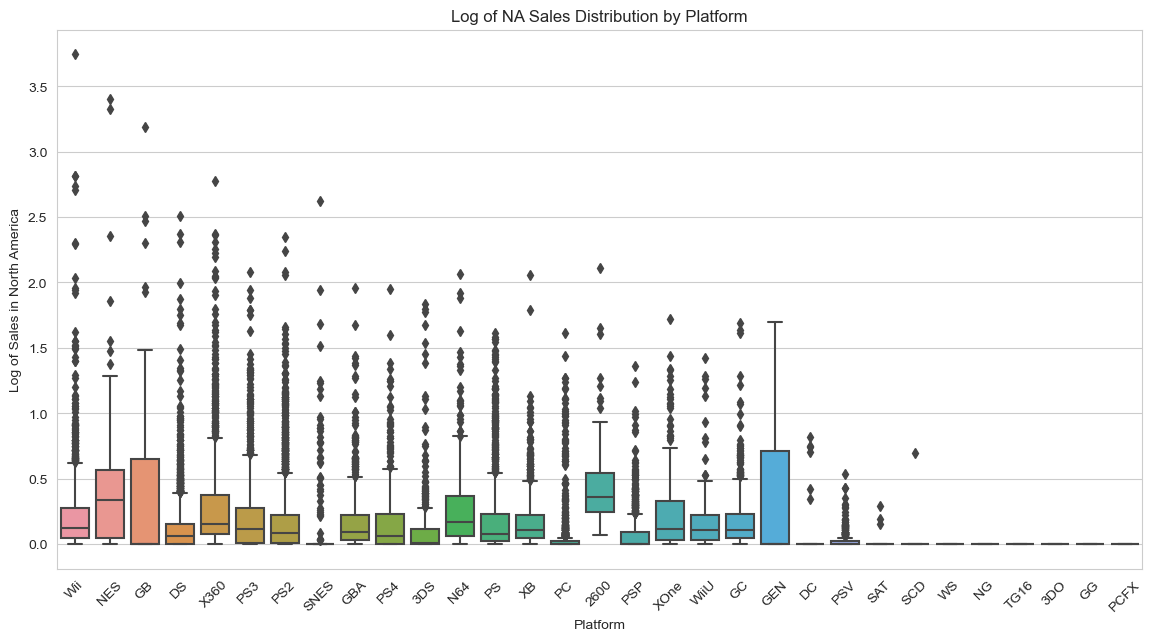

In [228]:
# Boxplot to compare sales across different genres
plt.figure(figsize=(14, 7))
sns.boxplot(x='Platform', y=log_sales, data=data)
plt.title('Log of NA Sales Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Log of Sales in North America')
plt.xticks(rotation=45)
plt.show()

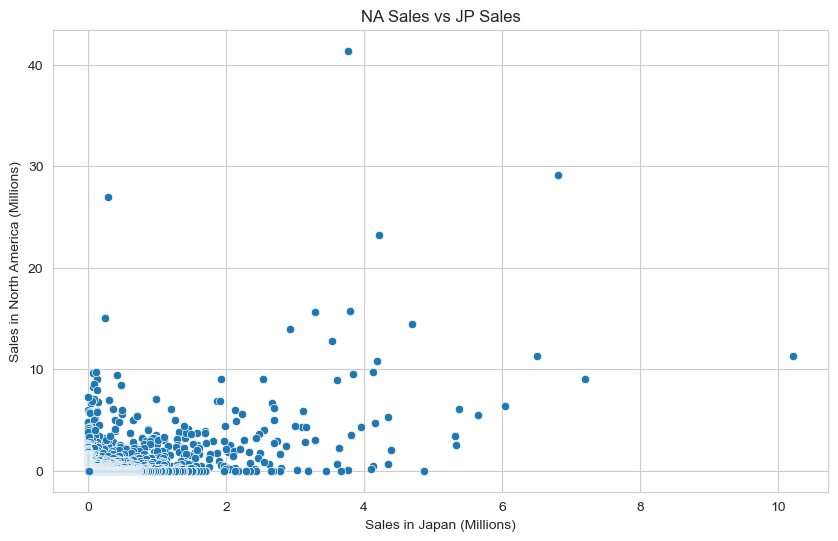

In [38]:
# Scatter plot of NA_Sales versus JP_Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='JP_Sales', y='NA_Sales', data=data)
plt.title('NA Sales vs JP Sales')
plt.xlabel('Sales in Japan (Millions)')
plt.ylabel('Sales in North America (Millions)')
plt.show()

c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


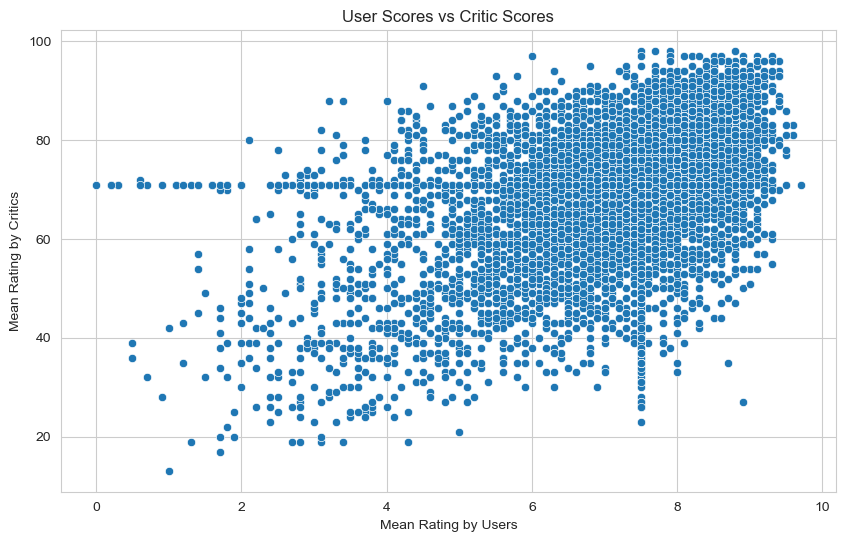

In [205]:
# Scatter plot of User Scores vs Critic Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x='User_Score', y='Critic_Score', data=data)
plt.title('User Scores vs Critic Scores')
plt.xlabel('Mean Rating by Users')
plt.ylabel('Mean Rating by Critics')
plt.show()

c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


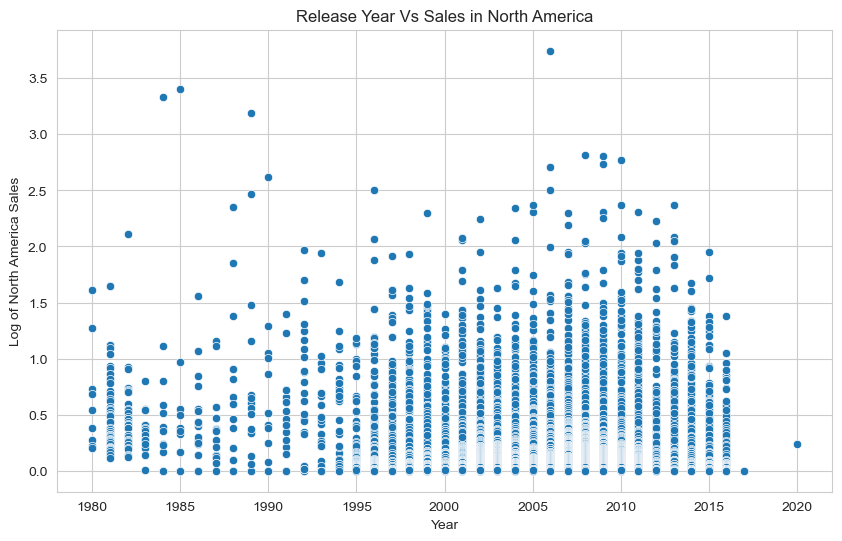

In [206]:
# Scatter plot of User Scores vs Critic Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year_of_Release', y=log_sales, data=data)
plt.title('Release Year Vs Sales in North America')
plt.xlabel('Year')
plt.ylabel('Log of North America Sales')
plt.show()

c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


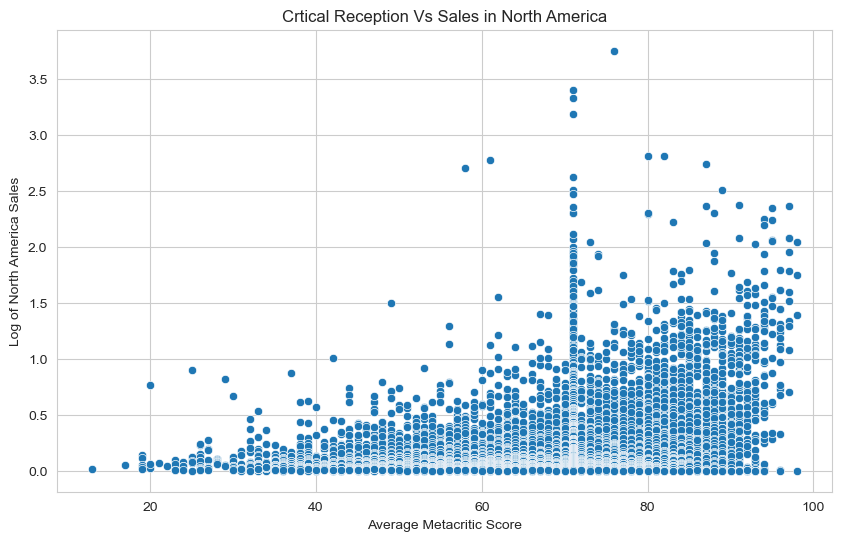

In [225]:
# Scatter plot of User Scores vs Critic Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Critic_Score', y=log_sales, data=data)
plt.title('Crtical Reception Vs Sales in North America')
plt.xlabel('Average Metacritic Score')
plt.ylabel('Log of North America Sales')
plt.show()

c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


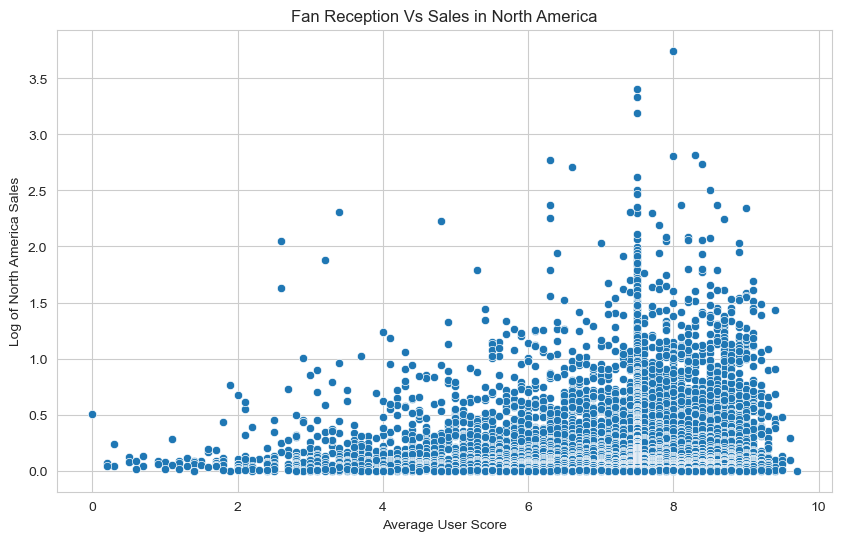

In [226]:
# Scatter plot of User Scores vs Critic Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x='User_Score', y=log_sales, data=data)
plt.title('Fan Reception Vs Sales in North America')
plt.xlabel('Average User Score')
plt.ylabel('Log of North America Sales')
plt.show()

In [111]:
# Select features
X = data.drop(['Name', 'Developer', 'NA_Sales', 'EU_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
y = data['NA_Sales']

In [112]:
# Define categorical features
categorical_features = ['Platform', 'Genre', 'Rating', 'Publisher']

In [113]:
# Create a ColumnTransformer with OneHotEncoder for categorical features
column_transformer = ColumnTransformer(
    [('cat', OneHotEncoder(), categorical_features)],
    remainder='passthrough'
)

# Apply the ColumnTransformer to the dataset
X_encoded = column_transformer.fit_transform(X)

In [114]:
# Applying log transformation to NA_Sales due to heavy right skewedness
y_log = np.log1p(y)  # log1p is used to handle zero sales values

In [115]:
# Split the transformed data
X_train, X_test, y_log_train, y_log_test = train_test_split(X_encoded, y_log, test_size=0.2, random_state=42)

In [116]:
# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_log_train)

# Predict and evaluate the model
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_log_test, y_pred_linear)
print(f'Linear Regression - MSE: {mse_linear:.2f}, R^2: {r2_score(y_log_test, y_pred_linear):.2f}')

Linear Regression - MSE: 0.05, R^2: 0.42


In [118]:
# Initialize and train the Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_log_train)

# Predict and evaluate the model
y_pred_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_log_test, y_pred_tree)
print(f'Decision Tree - MSE: {mse_tree:.2f}, R^2: {r2_score(y_log_test, y_pred_tree):.2f}')

Decision Tree - MSE: 0.06, R^2: 0.34


In [ ]:
# Parameter distribution for Decision Tree
param_dist_tree = {
    'max_depth': [None] + list(range(5, 20)),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create a DecisionTreeRegressor object
tree_model = DecisionTreeRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search_tree = RandomizedSearchCV(tree_model, param_distributions=param_dist_tree, 
                                        n_iter=50, scoring='neg_mean_squared_error', 
                                        cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search_tree.fit(X_train, y_log_train)

# Best model
best_tree = random_search_tree.best_estimator_

In [232]:
# Predict and evaluate
y_pred_tree = best_tree.predict(X_test)
mse_tree = mean_squared_error(y_log_test, y_pred_tree)
print(f'Optimized Decision Tree - MSE: {mse_tree:.2f}, R^2: {r2_score(y_log_test, y_pred_tree):.2f}')

Optimized Decision Tree - MSE: 0.04, R^2: 0.47


In [119]:
# Initialize and train the Random Forest model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_log_train)

# Predict and evaluate the model
y_pred_forest = forest_model.predict(X_test)
mse_forest = mean_squared_error(y_log_test, y_pred_forest)
print(f'Random Forest - MSE: {mse_forest:.2f}, R^2: {r2_score(y_log_test, y_pred_forest):.2f}')

Random Forest - MSE: 0.03, R^2: 0.61


In [120]:
# Initialize and train the GBM model
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_log_train)

# Predict and evaluate the model
y_pred_gbm = gbm_model.predict(X_test)
mse_gbm = mean_squared_error(y_log_test, y_pred_gbm)
print(f'Gradient Boosting - MSE: {mse_gbm:.2f}, R^2: {r2_score(y_log_test, y_pred_gbm):.2f}')

Gradient Boosting - MSE: 0.04, R^2: 0.54


In [ ]:
# Parameter distribution for Gradient Boosting
param_dist_gbm = {
    'n_estimators': range(50, 200),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': range(3, 10),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create a GradientBoostingRegressor object
gbm_model = GradientBoostingRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search_gbm = RandomizedSearchCV(gbm_model, param_distributions=param_dist_gbm, 
                                       n_iter=50, scoring='neg_mean_squared_error', 
                                       cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search_gbm.fit(X_train, y_log_train)

# Best model
best_gbm = random_search_gbm.best_estimator_


In [234]:
# Predict and evaluate
y_pred_gbm = best_gbm.predict(X_test)
mse_gbm = mean_squared_error(y_log_test, y_pred_gbm)
print(f'Optimized Gradient Boosting - MSE: {mse_gbm:.2f}, R^2: {r2_score(y_log_test, y_pred_gbm):.2f}')

Optimized Gradient Boosting - MSE: 0.03, R^2: 0.61


In [196]:
# Hyperparameter grid
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider at every split
    'max_depth': np.arange(10, 101, 10),        # Maximum number of levels in tree
    'min_samples_split': np.arange(2, 11, 2),   # Minimum number of samples required to split a node
    'min_samples_leaf': np.arange(1, 11, 2)     # Minimum number of samples required at each leaf node
}

# Create a RandomForestRegressor object
rf = RandomForestRegressor(random_state=42)

In [ ]:
# Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=param_dist,
                                   n_iter=77,            # Number of parameter settings sampled
                                   scoring='neg_mean_squared_error',
                                   cv=5,                  # 5-fold cross-validation
                                   verbose=2,     
                                   random_state=42,  
                                   n_jobs=-1)        

# Fit the random search model
random_search.fit(X_train, y_log_train)

In [198]:
# Best model from random search
best_rf = random_search.best_estimator_

# Predictions with the best model
y_pred_best = best_rf.predict(X_test)

# Compute and print the metrics
mse_best = mean_squared_error(y_log_test, y_pred_best)
r2_best = r2_score(y_log_test, y_pred_best)
print(f'Optimized Random Forest - MSE: {mse_best:.2f}, R^2: {r2_best:.2f}')

Optimized Random Forest - MSE: 0.04, R^2: 0.58


In [216]:
print(best_rf)

RandomForestRegressor(max_depth=80, max_features='sqrt', n_estimators=300,
                      random_state=42)


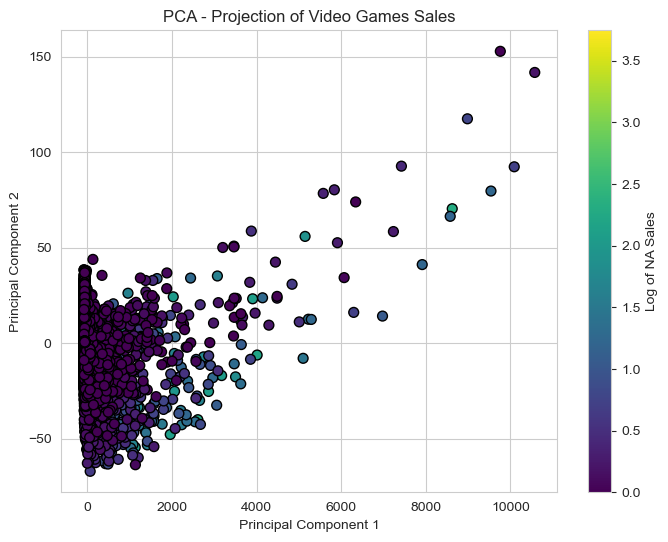

In [122]:
# Convert sparse matrix to dense
X_dense = X_encoded.toarray()

# Initialize PCA and reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_log, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='Log of NA Sales')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Projection of Video Games Sales')
plt.show()

In [182]:
# Initialize the StandardScaler
scaler = StandardScaler(with_mean=False)

X_scaled = scaler.fit_transform(X_encoded)

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_scaled)  # Apply TruncatedSVD to the scaled sparse data


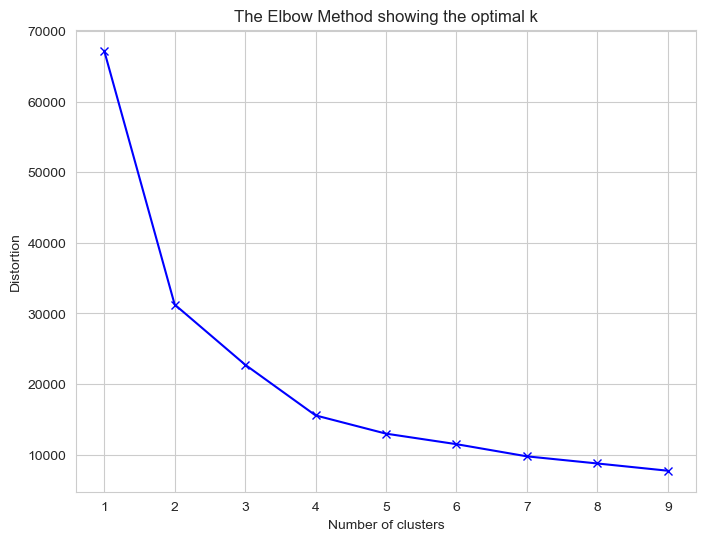

In [183]:
# elbow method to determine number of clusters

distortions = []
K = range(1, 10)  # Test different numbers of clusters
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(X_svd)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

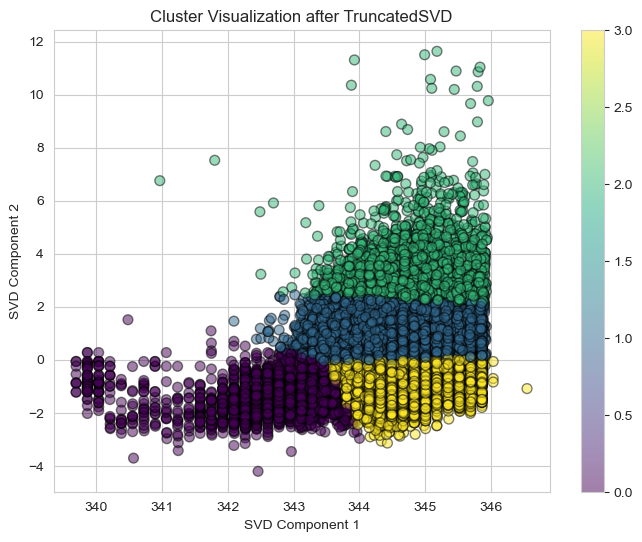

In [184]:

# Apply k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_svd)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50, alpha=0.5)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Cluster Visualization after TruncatedSVD')
plt.colorbar()
plt.show()


In [209]:
# Get centroids
centroids = kmeans.cluster_centers_
print(centroids)

[[342.77419372  -1.38392023]
 [344.47791714   1.04655152]
 [344.7571267    3.53656669]
 [344.64632045  -1.0292676 ]]


In [212]:
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = clusters

In [213]:
# Filter to get only numeric columns for aggregation
numeric_cols = data_with_clusters.select_dtypes(include=[np.number])  # Only include numeric columns

# Now add the Cluster column back for grouping
numeric_cols['Cluster'] = data_with_clusters['Cluster']

# Now group by Cluster and calculate the mean of numeric columns
cluster_summary = numeric_cols.groupby('Cluster').mean()
print(cluster_summary)

         Year_of_Release  NA_Sales  EU_Sales  JP_Sales  Other_Sales  \
Cluster                                                               
0            1997.979197  0.332121  0.140073  0.173709     0.027319   
1            2007.992355  0.242130  0.139023  0.039794     0.052043   
2            2009.493957  0.531955  0.346978  0.041456     0.123106   
3            2008.932477  0.166805  0.094359  0.065474     0.032680   

         Global_Sales  Critic_Score  Critic_Count  User_Score  User_Count  
Cluster                                                                    
0            0.673402     70.182537     18.859361    7.505391   24.732493  
1            0.473281     68.721809     23.482693    7.205670   46.276917  
2            1.043552     74.861272     45.229112    7.187704  513.769837  
3            0.359638     69.451300     19.973409    7.367941   25.453690  


In [214]:
# For non-numeric data using mode
non_numeric_cols = data_with_clusters.select_dtypes(exclude=[np.number])

# Adding the 'Cluster' label for grouping
non_numeric_cols['Cluster'] = data_with_clusters['Cluster']

# Using mode for non-numeric data
mode_summary = non_numeric_cols.groupby('Cluster').agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
print(mode_summary)

                                 Name Platform    Genre           Publisher  \
Cluster                                                                       
0                     Madden NFL 2002       PS   Sports            Nintendo   
1        LEGO Harry Potter: Years 5-7      PS2   Action     Electronic Arts   
2                    Alien: Isolation     X360  Shooter     Electronic Arts   
3                                Cars       DS   Sports  Namco Bandai Games   

                Developer Rating  
Cluster                           
0               EA Sports      E  
1                 Ubisoft      T  
2        Ubisoft Montreal      M  
3               EA Canada      E  


In [215]:
# Combine the numeric and non-numeric summaries
combined_summary = pd.concat([cluster_summary, mode_summary], axis=1)
print(combined_summary)

         Year_of_Release  NA_Sales  EU_Sales  JP_Sales  Other_Sales  \
Cluster                                                               
0            1997.979197  0.332121  0.140073  0.173709     0.027319   
1            2007.992355  0.242130  0.139023  0.039794     0.052043   
2            2009.493957  0.531955  0.346978  0.041456     0.123106   
3            2008.932477  0.166805  0.094359  0.065474     0.032680   

         Global_Sales  Critic_Score  Critic_Count  User_Score  User_Count  \
Cluster                                                                     
0            0.673402     70.182537     18.859361    7.505391   24.732493   
1            0.473281     68.721809     23.482693    7.205670   46.276917   
2            1.043552     74.861272     45.229112    7.187704  513.769837   
3            0.359638     69.451300     19.973409    7.367941   25.453690   

                                 Name Platform    Genre           Publisher  \
Cluster                        

In [129]:
if isinstance(X_encoded, scipy.sparse.csr.csr_matrix):
    X_dense = X_encoded.toarray()
else:
    X_dense = X_encoded

# Use X_dense for model training and SHAP analysis
X_train, X_test, y_log_train, y_log_test = train_test_split(X_dense, y_log, test_size=0.2, random_state=42)

# Continue with model training and SHAP analysis
forest_model.fit(X_train, y_log_train)
explainer = shap.TreeExplainer(forest_model)
shap_values = explainer.shap_values(X_test, check_additivity=False)

C:\Users\natel\AppData\Local\Temp\ipykernel_27472\519507941.py:1: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(X_encoded, scipy.sparse.csr.csr_matrix):


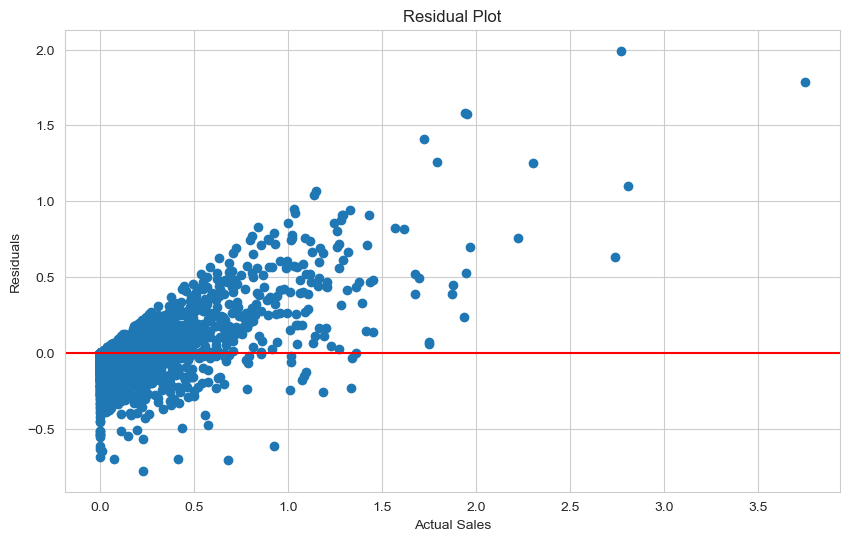

14    1.991970
31    1.574467
0     1.785400
61    1.584371
Name: NA_Sales, dtype: float64
903     -0.775365
2225    -0.697524
184     -0.704342
10097   -0.697575
Name: NA_Sales, dtype: float64


In [135]:
# Calculate residuals
residuals = y_log_test - y_pred_forest

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_log_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Identify extreme cases
high_positive_residuals = residuals[residuals > residuals.quantile(0.999)]  # top 0.1% overestimations
high_negative_residuals = residuals[residuals < residuals.quantile(0.001)]  # bottom 0.1%

print(high_positive_residuals)
print(high_negative_residuals)

In [236]:
# Retrieve names for high positive residuals
high_positive_names = data.loc[high_positive_residuals.index, 'Name']
print("High Positive Residuals - Names:")
print(high_positive_names)

# Retrieve names for high negative residuals
high_negative_names = data.loc[high_negative_residuals.index, 'Name']
print("High Negative Residuals - Names:")
print(high_negative_names)

High Positive Residuals - Names:
14           Kinect Adventures!
31    Call of Duty: Black Ops 3
0                    Wii Sports
61                 Just Dance 3
Name: Name, dtype: object
High Negative Residuals - Names:
903      PaRappa The Rapper
2225              Bayonetta
184          Tomodachi Life
10097                  Zubo
Name: Name, dtype: object


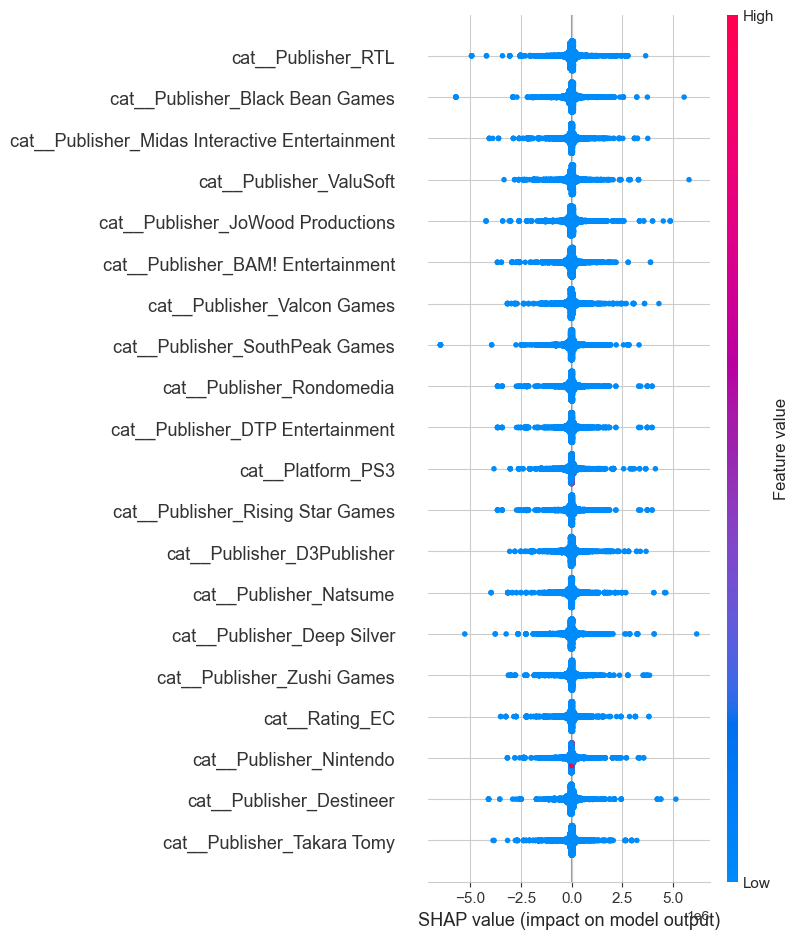

In [137]:
feature_names = column_transformer.get_feature_names_out()
# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [163]:
# Select relevant categorical features
data2 = data[['Platform', 'Genre', 'Publisher', 'Rating', 'Critic_Score', 'User_Score']]

# Turn Numerical features into cateogrical
data2['Critic_Score_Bin'] = pd.cut(data2['Critic_Score'], bins=[0, 50, 70, 90, 100], labels=['c_Low', 'c_Medium', 'c_High', 'c_Very High'])
data2['User_Score_Bin'] = pd.cut(data2['User_Score'], bins=[0, 50, 70, 90, 100], labels=['u_Low', 'u_Medium', 'u_High', 'u_Very High'])

# Drop rows with any missing values in the selected columns
data2.dropna(subset=['Platform', 'Genre', 'Publisher', 'Rating', 'Critic_Score_Bin', "User_Score_Bin"], inplace=True)

# Convert all columns to string to ensure consistency
categorical_data2 = data2[['Platform', 'Genre', 'Publisher', 'Rating', 'Critic_Score_Bin', 'User_Score_Bin']].astype(str)

# Encode the data for the Apriori algorithm
te = TransactionEncoder()
te_ary = te.fit(categorical_data2.values).transform(categorical_data2.values)
df2 = pd.DataFrame(te_ary, columns=te.columns_)

C:\Users\natel\AppData\Local\Temp\ipykernel_27472\4280543777.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Critic_Score_Bin'] = pd.cut(data2['Critic_Score'], bins=[0, 50, 70, 90, 100], labels=['c_Low', 'c_Medium', 'c_High', 'c_Very High'])
C:\Users\natel\AppData\Local\Temp\ipykernel_27472\4280543777.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['User_Score_Bin'] = pd.cut(data2['User_Score'], bins=[0, 50, 70, 90, 100], labels=['u_Low', 'u_Medium', 'u_High', 'u_Very High'])
C:\Users\n

In [164]:
# Proceed with Apriori and association rules
frequent_itemsets2 = apriori(df2, min_support=0.01, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.1)

In [165]:
# Display the resulting rules
print(rules2[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

          antecedents                 consequents   support  confidence  \
0               (3DS)                    (Action)  0.011245    0.361538   
1               (3DS)                         (E)  0.022969    0.738462   
2               (3DS)                    (c_High)  0.025362    0.815385   
3               (3DS)                     (u_Low)  0.031104    1.000000   
4         (505 Games)                     (u_Low)  0.011425    1.000000   
...               ...                         ...       ...         ...   
2526         (PS2, E)     (c_High, u_Low, Sports)  0.015074    0.203883   
2527  (u_Low, Sports)            (c_High, E, PS2)  0.015074    0.107325   
2528      (E, Sports)        (c_High, PS2, u_Low)  0.015074    0.124322   
2529            (PS2)  (c_High, E, u_Low, Sports)  0.015074    0.116613   
2530         (Sports)     (c_High, E, PS2, u_Low)  0.015074    0.107325   

          lift  
0     1.792467  
1     1.147467  
2     1.095524  
3     1.000000  
4     1.000000

In [168]:
# Filter rules by lift
high_lift_rules = rules2[rules2['lift'] > 1.5]  # Adjust the threshold as needed

# Sort by lift in descending order
high_lift_rules = high_lift_rules.sort_values(by='lift', ascending=False)
print(high_lift_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

                                  antecedents  \
1875         (Sony Computer Entertainment, E)   
1878                              (PS, u_Low)   
708          (Sony Computer Entertainment, E)   
1872  (Sony Computer Entertainment, E, u_Low)   
711                                      (PS)   
1880                                     (PS)   
2178                       (c_High, M, u_Low)   
2183                         (Shooter, u_Low)   
1015                              (c_High, M)   
1017                                (Shooter)   

                                  consequents   support  confidence      lift  
1875                              (PS, u_Low)  0.010468    0.360082  5.029119  
1878         (Sony Computer Entertainment, E)  0.010468    0.146199  5.029119  
708                                      (PS)  0.010468    0.360082  5.029119  
1872                                     (PS)  0.010468    0.360082  5.029119  
711          (Sony Computer Entertainment, E)  0.010468    0

In [169]:
# Filter rules by leverage
high_leverage_rules = rules2[rules2['leverage'] > 0.01]  # Adjust the threshold as needed

# Sort by leverage in descending order
high_leverage_rules = high_leverage_rules.sort_values(by='leverage', ascending=False)
print(high_leverage_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

         antecedents      consequents   support  confidence      lift
898         (c_High)       (E, u_Low)  0.550365    0.739452  1.149006
897       (E, u_Low)         (c_High)  0.550365    0.855191  1.149006
896  (c_High, u_Low)              (E)  0.550365    0.739452  1.149006
116         (c_High)              (E)  0.550365    0.739452  1.149006
117              (E)         (c_High)  0.550365    0.855191  1.149006
899              (E)  (c_High, u_Low)  0.550365    0.855191  1.149006
107         (Sports)              (E)  0.121247    0.863288  1.341430
106              (E)         (Sports)  0.121247    0.188400  1.341430
844       (E, u_Low)         (Sports)  0.121247    0.188400  1.341430
846  (u_Low, Sports)              (E)  0.121247    0.863288  1.341430


In [193]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_scaled.shape[1]),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)


c:\Users\natel\anaconda3\envs\stat386\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [194]:
# Fit the model
history = model.fit(X_scaled, y_log, epochs=50, batch_size=16, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Predict and evaluate
predictions = model.predict(X_scaled)

mse = mean_squared_error(y_log, predictions)
print("Mean Squared Error:", mse)

Epoch 1/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5144 - val_loss: 0.6546
Epoch 2/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - loss: 0.3166 - val_loss: 0.2269
Epoch 3/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - loss: 0.1338 - val_loss: 0.1330
Epoch 4/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1074 - val_loss: 0.0866
Epoch 5/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - loss: 0.0945 - val_loss: 0.0743
Epoch 6/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - loss: 0.0767 - val_loss: 0.1087
Epoch 7/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - loss: 0.0839 - val_loss: 0.0657
Epoch 8/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - loss: 0.0663 - val_loss: 0.0348
Epoch 9/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0670 - val_loss: 0.0367
Epoch 10/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - loss: 0.0581 - val_loss: 0.0233
Epoch 11/50
836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - loss: 0.0607 - val_loss: 0.0181
Epoch 12/50
836/836 ━━━━━━━━━━━━━━━━